In [15]:
import cv2
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt
import keras.backend as K
import math

In [2]:
def makeDir(path):
    try:
        if not os.path.exists(path):
            os.makedirs(path)
    except OSError:
        print('Error: Creating directory. ' + directory)

img -> flow -> hsv -> rgb

In [21]:
def Flow2BGR_save(img1, img2, path):
    hsv = np.zeros_like(img1)
    hsv[...,1] = 255

    img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)

    flow = cv2.calcOpticalFlowFarneback(img1,img2, None, 0.5, 3, 15, 3, 5, 1.2, 0)

    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = np.minimum(mag*4, 255)
    bgr = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
    
    bgr = cv2.resize(bgr, (320,192))

    cv2.imwrite(path,bgr)

BGR -> HSV -> ang,mag -> flow

In [4]:
def BGR2Flow(bgr):
    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
    ang = hsv[...,0]/(180/np.pi/2)
    mag = hsv[...,2]/4
    
    flow = np.zeros((bgr.shape[0],bgr.shape[1],2))
    
    reflow = cv2.polarToCart(mag,ang,flow.shape[0],flow.shape[1],angleInDegrees=0)
    reflow = np.array(reflow)
    for i in range(reflow.shape[1]):
        for j in range(reflow.shape[2]):
            flow[i,j,0] = reflow[0,i,j]
            flow[i,j,1] = reflow[1,i,j]
    return flow

In [5]:
def Flow2BGR_img(flow):
    hsv = np.zeros((flow.shape[0], flow.shape[1], 3))
    hsv[...,1] = 255
    
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = np.minimum(mag*4, 255)
    hsv = hsv.astype('uint8')
    bgr = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
    return bgr

In [6]:
def FlowFrame(img, flow, F = 1):
    reimg = np.zeros_like(img)   
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):       
            y = int(i + (flow[i,j,1]/F))
            x = int(j + (flow[i,j,0]/F))        
            if y>=img.shape[0] or y<0 or x>=img.shape[1] or x<0:
                img[i,j] = 0
                continue
            reimg[i,j] = img[y,x]
    return reimg

In [7]:
test_list = pd.read_csv('data/adobe240fps/test_list.txt',header=None)
train_list = pd.read_csv('data/adobe240fps/train_list.txt',header=None)

In [16]:
makeDir('data/train/resizeflow_ori')

Get Optical Flow BGR

In [ ]:
for i in range(len(train_list)):
    print("%d / %d"%(i, len(train_list)))
    length = len(os.walk("data/train/true/"+train_list.iloc[i,0].split('.')[0]).__next__()[2])-8
    makeDir("data/train/resizeflow_ori/" + train_list.iloc[i,0].split('.')[0])
    for j in range(length):
        img1 = cv2.imread("data/train/true/"+ train_list.iloc[i,0].split('.')[0] + "/frame%d"%j + ".jpg", cv2.IMREAD_COLOR)
        img3 = cv2.imread("data/train/true/"+ train_list.iloc[i,0].split('.')[0] + "/frame%d"%(j+8) + ".jpg", cv2.IMREAD_COLOR)
        img2 = cv2.imread("data/train/true/"+ train_list.iloc[i,0].split('.')[0] + "/frame%d"%(j+4) + ".jpg", cv2.IMREAD_COLOR)
        path = "data/train/resizeflow_ori/" + train_list.iloc[i,0].split('.')[0] + "/frame%d"%j +"_01.jpg"
        Flow2BGR_save(img1, img2, path)
        path = "data/train/resizeflow_ori/" + train_list.iloc[i,0].split('.')[0] + "/frame%d"%j +"_10.jpg"
        Flow2BGR_save(img3, img2, path)

0 / 112
1 / 112
2 / 112
3 / 112


Calc Optical Flow frome BGR

In [23]:
bgr = cv2.imread("data/train/flow/720p_240fps_2/frame0_01.jpg")
img = cv2.imread("data/train/resize/720p_240fps_2/frame8.jpg")

flow = BGR2Flow(bgr)
reimg = np.zeros_like(img)

for k in range(1,8):
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):       
            y = int(i + (flow[i,j,1] * k/8))
            x = int(j + (flow[i,j,0] * k/8))        
            if y>=img.shape[0] or y<0 or x>=img.shape[1] or x<0:
                img[i,j] = 0
                continue
            reimg[i,j] = img[y,x]
    cv2.imwrite('reimg%d.jpg'%k,reimg)

In [26]:
data_length = len(os.walk("data/train/flow").__next__()[1])

In [27]:
data_length

112

In [39]:
len(os.walk("data/train/resize/"+train_list.iloc[0,0].split('.')[0]).__next__()[2])

300

In [51]:
np.savez_compressed('bgr_img_com', d1=bgr,d2=img)

In [76]:
bi = np.load('bgr_img.npz')

In [83]:
bi.close()

True

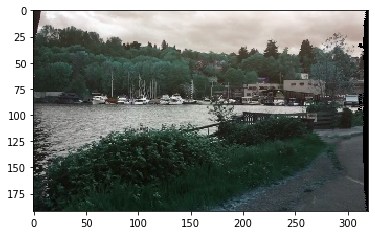

In [14]:
bgr = cv2.imread("test img/res/ch1/frame0.jpg")
img = cv2.imread("data/train/resize/720p_240fps_2/frame8.jpg")

#bgr = cv2.resize(bgr, (1280,720))

imFlow = BGR2Flow(bgr)
frame = FlowFrame(img,imFlow)

plt.imshow(frame)
cv2.imwrite('new.jpg',frame)

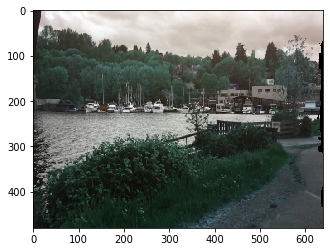

In [73]:
bgr = cv2.imread("data/train/flow/720p_240fps_2/frame0_01.jpg")
img = cv2.imread("data/train/half/720p_240fps_2/frame8.jpg")

bgr = cv2.resize(bgr, (640,480))

imFlow = BGR2Flow(bgr)
frame = FlowFrame(img,imFlow)

plt.imshow(frame)

In [76]:
cv2.imwrite("resize_small1.jpg", frame)

True

In [79]:
b1 = cv2.imread("data/train/resizeflow/720p_240fps_2/frame0_01.jpg")
b2 = cv2.imread("data/train/resizeflow/720p_240fps_2/frame1_01.jpg")

f1 = BGR2Flow(b1)
f2 = BGR2Flow(b2)

In [83]:
np.linalg.norm(f1-f2, axis=2).shape

(192, 320)

In [117]:
np.linalg.norm(b1.T[0]-b2.T[0], axis=-1)

array([ 954.13363844,  987.62543507,  883.36855276, 1222.95461895,
       1373.03969353, 1442.15047759, 1464.86552284, 1508.60332758,
       1571.92843349, 1486.89643217, 1419.78554719, 1373.22285154,
       1419.78589935, 1349.33983859, 1222.52811829, 1195.63874143,
       1168.58504183,  883.38157101,  570.24117705,  570.23328559,
       1018.02013733, 1109.69995945,  919.42590784,  883.35496829,
        765.00915027, 1020.00441176,  510.01764675,  510.01666639,
        441.71936792,  510.03627322,  509.04027346,  569.34875077,
       1019.50478174, 1019.50527218, 1050.67121403, 1019.01422954,
        721.27248665,  570.22890141,  570.22364034,  570.21750236,
       1081.64827925, 1020.00980387, 1140.39905296,  765.00653592,
        806.38638381,  721.25515596,  845.75823969,  845.75823969,
        720.5796278 ,  720.5796278 ,  674.68955824,  674.68733499,
        624.62468731,  624.62468731, 1709.99853801, 1766.11721015,
       1838.14009259, 1802.41754319, 1441.97052674, 1441.97052

In [136]:
sum((b1.T[0]-b2.T[0])**2)

array([ 30,  58,  85, 100, 106, 103,  88, 105,  47,  51,  25,  31,  30,
        46, 109, 103,  64,  71,  73,  72,  56,  61,  62,  73,  71,  68,
        67,  77,  88, 111, 113, 110,  99, 102,  90,  89,  84,  84, 108,
       108, 117, 119, 104, 103, 112, 112, 114, 113, 116, 114, 159, 127,
       124, 133, 130, 133, 118, 118, 121, 114, 149, 172, 123, 118,  93,
        77,  78,  87,  95,  90, 109,  99, 111, 109,  99,  91,  96, 104,
       117, 176,  75,  69,  74,  73,  99, 101,  69,  64,  67,  61,  49,
        58,  68,  68,  76,  74,  84, 106,  84,  87, 102,  88, 104, 107,
       116, 100, 106, 114,  94,  91, 165, 183, 121, 131, 105,  92,  86,
        89, 129, 124, 102, 131, 112, 106,  88,  84,  70,  82, 125, 127,
        96,  95,  84,  89, 156, 161, 131, 128,  90,  90,  82,  95, 116,
       116, 110,  95, 109, 111, 110, 121, 122, 142,  94, 100, 124, 121,
        81, 103, 128, 174, 157, 130, 119, 123, 113, 114, 109, 113, 103,
       103, 112, 110,  86,  83,  84,  93, 140, 147,  83,  73,  7

In [99]:
res = np.array([])
res = np.append(res,K.sqrt(K.sum(K.square(c1[0] - c2[0]), axis=-1)))
res = np.append(res,K.sqrt(K.sum(K.square(c1[1] - c2[1]), axis=-1)))
res = np.append(res,K.sqrt(K.sum(K.square(c1[2] - c2[2]), axis=-1)))

res

array([<tf.Tensor 'Sqrt_12:0' shape=(320,) dtype=float64>,
       <tf.Tensor 'Sqrt_13:0' shape=(320,) dtype=float64>,
       <tf.Tensor 'Sqrt_14:0' shape=(320,) dtype=float64>], dtype=object)

In [89]:
c1 = b1.astype(float)
c2 = b2.astype(float)

In [111]:
b1.T[0].shape

(320, 192)

In [131]:
test = [[1,2],[4,5]]
test = np.array(test)
test

array([[1, 2],
       [4, 5]])